In [137]:
#first version
#ANALYZING DATA
#some empty spaces, maybe some duplicates, 
#1IMPORT all libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt




In [138]:
data= pd.read_csv("SalaryData.csv") #read the csv file

data.drop(columns='Job Title', inplace=True)
#Let's clean raw data
#1) impute missing values
#2) drop dulpicates 
#3) one-hot encoding catergoical data
#4) remove outliers
#5)combine highly correlated data



#LET's see the data

data.head()


,Age,Gender,Education Level,Years of Experience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


In [139]:

#Solution 1 : impute missing values
#calculate the missing data 
#What we saw? two rows are missing from the dataset
data.dropna(inplace=True)
data.isnull().sum()


#check: we all good 

Age                    0
Gender                 0
Education Level        0
Years of Experience    0
Salary                 0
dtype: int64

In [140]:
#Solution 2: Drop dulpicates
data.drop_duplicates(inplace=True) 

In [141]:
#Solution 3:  one-hot encoding catergoical data

#whats werid about this data,is the name is not fit for ml
#let's rename
data.rename(columns={
    "Education Level": "edu_level",
    "Gender" : "gend"
},
    inplace=True
)

data.head()
#check : we good


#check: if it works , now transfer data

,Age,gend,edu_level,Years of Experience,Salary
0,32.0,Male,Bachelor's,5.0,90000.0
1,28.0,Female,Master's,3.0,65000.0
2,45.0,Male,PhD,15.0,150000.0
3,36.0,Female,Bachelor's,7.0,60000.0
4,52.0,Male,Master's,20.0,200000.0


In [142]:

data_encoded = pd.get_dummies(data=data, columns=['edu_level', 'gend'], dtype=int)

In [143]:
data_encoded.isnull().sum()

Age                     0
Years of Experience     0
Salary                  0
edu_level_Bachelor's    0
edu_level_Master's      0
edu_level_PhD           0
gend_Female             0
gend_Male               0
dtype: int64

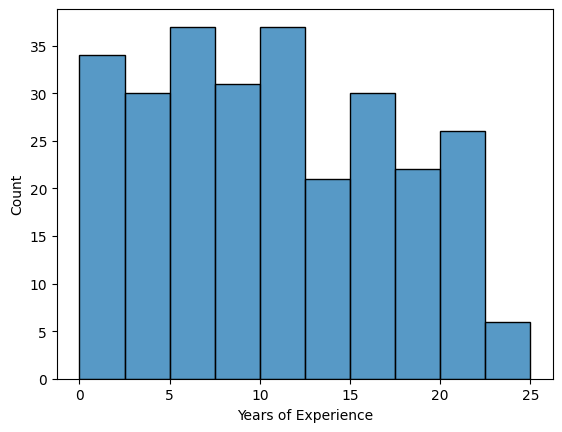

In [144]:
#Solution 4: remove outliers
# first let's visualize the outliers

#
sns.histplot(x=data_encoded['Years of Experience'])

#this dataset is not normally distributed

# individually work: 
IQR = data_encoded['Salary'].quantile(0.75) - data_encoded['Salary'].quantile(0.25)

#individually work: 
lower_bound= data_encoded['Salary'].quantile(0.25)-(IQR*1.5)
#individually work: 
upper_bound= data_encoded['Salary'].quantile(0.75)+(IQR*1.5)


<Axes: ylabel='Salary'>

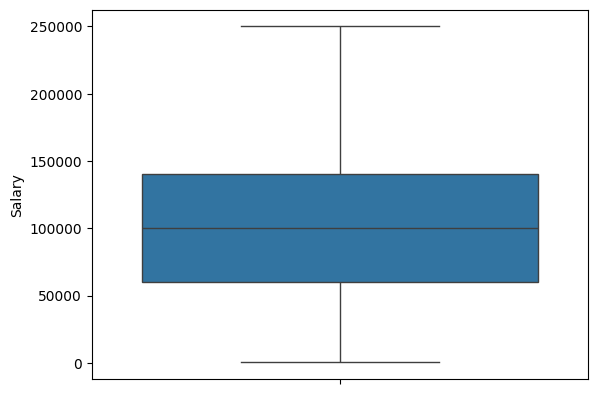

In [145]:
# see outliers
sns.boxplot(data_encoded['Salary'])

In [146]:
#trimming -delete the outlier data
## way to look individually
new_df = data_encoded.loc[(data_encoded['Salary'] < upper_bound) & (data_encoded['Salary'] > lower_bound) ]
print("before removing outliers: ", len(data))
print("after removing outliers: ", len(new_df))
print("outliers: ", len(data) - len(new_df))


#important fact: ONLY NUMERIC DATA is considered when removing outliers, not catergoical data

before removing outliers:  274
after removing outliers:  274
outliers:  0


In [147]:
#Solution 5: combine highely correlated data 
columns = ['Age', 'Salary', 'Years of Experience']
corr = data[columns].corr()

print(corr)

                          Age    Salary  Years of Experience
Age                  1.000000  0.902580             0.977241
Salary               0.902580  1.000000             0.911253
Years of Experience  0.977241  0.911253             1.000000


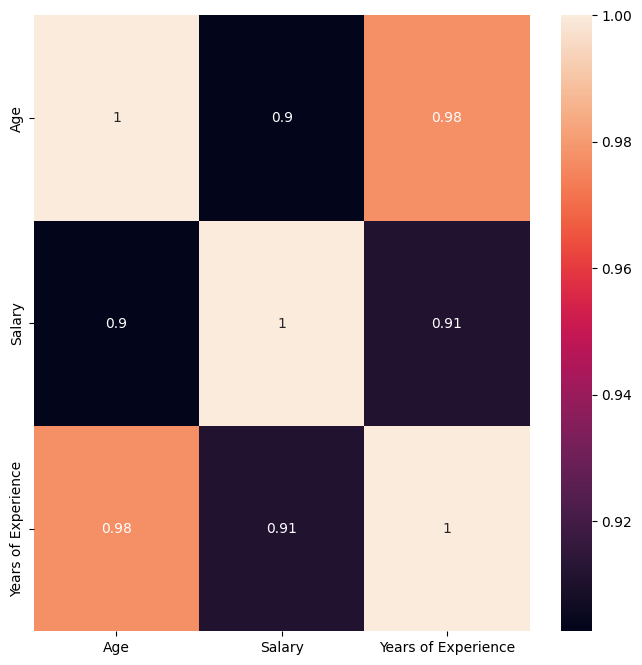

In [148]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, annot=True)

plt.show()

In [149]:
#lets find correlation among catergoical variables in python

from scipy.stats import chi2_contingency

def is_correlated(x,y):
    crossl= pd.crosstab(index=data[x], columns=data[y])
    chi_sq_result= chi2_contingency(crossl)
    p_value = chi_sq_result[1]
    correlation_statement= "correlated" if p_value < 0.05 else "not-corelated"
    print(f"P-value: {p_value:}, The variables are {correlation_statement}.")




In [150]:
is_correlated('edu_level', 'gend')
#no correlation

P-value: 0.5692879591802311, The variables are not-corelated.


In [151]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBRegressor

In [152]:
#now time to split our data
#however first we need to identify x and y 

x=data_encoded.drop('Salary', axis=1)
y=data_encoded["Salary"]

##to esnure whats going on
##print(x)
##print(y)
x_train,x_test,y_train,y_test = train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)


#random_state matters


#other way you takeaway for catergoical data in XG boost

#cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
#for col in cats:
  # X[col] = X[col].astype('category')



In [153]:
#Create model and fit into model
xgb_model= XGBRegressor()
xgb_model.fit(x_train,y_train)




XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [154]:
y_pred_train = xgb_model.predict(x_train)

from sklearn.metrics import r2_score

score = r2_score(y_train,y_pred_train)

print("R^2 - {}%".format(round(score,2)*100))

#r^2 shows overfitting, however not to bad 


R^2 - 98.0%


In [155]:
#run the predictions  of training and test

y_xgb_predtest = xgb_model.predict(x_test)

In [156]:
#now we evaulate how we have done

xgb_pred_test= pd.DataFrame({'Actual:': y_test, "Predicted: ": y_xgb_predtest})
xgb_pred_test

,Actual:,Predicted:
30,250000.0,200000.750000
181,105000.0,104935.875000
216,95000.0,99874.492188
132,100000.0,97473.890625
339,70000.0,51282.453125
...,...,...
84,40000.0,42980.753906
118,45000.0,45153.066406
57,140000.0,157914.421875
116,65000.0,131345.000000


In [157]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

score = r2_score(y_test,y_xgb_predtest)

print("R^2 - {}%".format(round(score,2)*100))

mae = mean_absolute_error(y_test, y_xgb_predtest)
print('Mean Absolute Error:', mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_xgb_predtest)
print('Mean Squared Error:', mse)



R^2 - 73.0%
Mean Absolute Error: 16924.3015813253
Mean Squared Error: 559585637.4685888


In [158]:
graph_check_df=pd.DataFrame({'Actual': y_test, 'Predicted': y_xgb_predtest})

graph_check_df 



,Actual,Predicted
30,250000.0,200000.750000
181,105000.0,104935.875000
216,95000.0,99874.492188
132,100000.0,97473.890625
339,70000.0,51282.453125
...,...,...
84,40000.0,42980.753906
118,45000.0,45153.066406
57,140000.0,157914.421875
116,65000.0,131345.000000


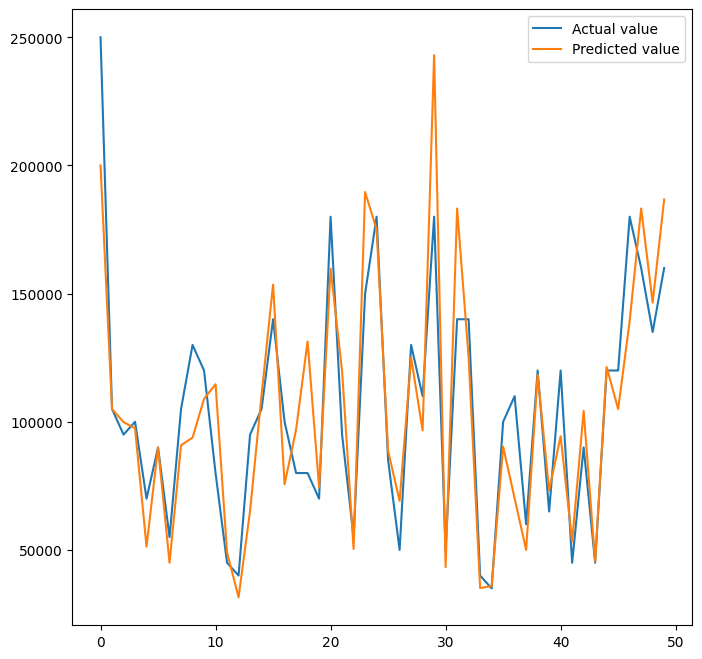

In [159]:
fig = plt.figure(figsize=(8,8))
graph_new=graph_check_df.reset_index()
graph_new_new=graph_new.drop(['index'],axis=1)
plt.plot(graph_new_new[:50])
plt.legend(['Actual value', 'Predicted value'])
